In [156]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


In [157]:
df = pd.read_csv('accommodation_data_final.csv')  # Adjust filename if needed
print(df.head())


   PRICE_PER_NIGHT  TAX_AMOUNT                         ACCOM_NAME_EN  \
0              5.8        4.35                        Al Kiram Hotel   
1              6.6        4.95                     Elaf Bakkah Hotel   
2              6.6        4.95                     Elaf Bakkah Hotel   
3              7.2        5.40                           Roots Hotel   
4              7.6        5.70  M Hotel Al Dana Makkah by Millennium   

  ACCOM_TYPE_CODE BOOKING_PROVIDER_NAME_EN ROOM_TYPE_CODE CITY_NAME_EN  \
0           Hotel                AGODA.COM      Twin Room        Mecca   
1           Hotel                PRICELINE      Twin Room        Mecca   
2           Hotel         ELAF KINDA HOTEL  Standard Room        Mecca   
3           Hotel                SUPER.COM  Superior Room        Mecca   
4           Hotel                SUPER.COM  Standard Room        Mecca   

  REVIEW_SCORE_NAME_EN  STAR_RATING_CODE  
0                 Good                 3  
1            Very Good              

In [158]:
score_map = {
    "poor": 1,
    "mediocre": 2,
    "fair": 3,
    "acceptable": 4,
    "okay": 5,
    "good": 6,
    "very good": 7,
    "excellent": 8,
    "amazing": 9,
    "wonderful": 10
}
df['REVIEW_SCORE_ORDERED'] = df['REVIEW_SCORE_NAME_EN'].str.strip().str.lower().map(score_map)


In [159]:
cols_needed = [
    'PRICE_PER_NIGHT', 'TAX_AMOUNT', 'STAR_RATING_CODE',
    'ACCOM_TYPE_CODE', 'ROOM_TYPE_CODE', 'CITY_NAME_EN', 'REVIEW_SCORE_ORDERED'
]  # Removed 'BOOKING_PROVIDER_NAME_EN'

df_clean = df.dropna(subset=cols_needed)
print(df_clean.shape)


(16956, 10)


In [160]:
features = [
    'PRICE_PER_NIGHT', 'TAX_AMOUNT', 'STAR_RATING_CODE',
    'ACCOM_TYPE_CODE', 'BOOKING_PROVIDER_NAME_EN',
    'ROOM_TYPE_CODE', 'CITY_NAME_EN'
]
X = pd.get_dummies(df_clean[features], drop_first=True)
y = df_clean['REVIEW_SCORE_ORDERED']


In [161]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(X_train.shape, X_test.shape)


(13564, 51) (3392, 51)


In [162]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("R²:", r2_score(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred) ** 0.5)
print("MAE:", mean_absolute_error(y_test, y_pred))

# Feature importance
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_
}).sort_values('Coefficient', ascending=False)
print(coef_df)


R²: 0.3368094817894032
RMSE: 0.9239467126196119
MAE: 0.5529986713876451
                                              Feature  Coefficient
0                                     PRICE_PER_NIGHT    21.547163
43                               ROOM_TYPE_CODE_Suite     0.731918
47                         ROOM_TYPE_CODE_Villa Rooms     0.394871
50                                CITY_NAME_EN_Riyadh     0.324044
2                                    STAR_RATING_CODE     0.234685
48                             CITY_NAME_EN_Al Maqrah     0.094667
40                     ROOM_TYPE_CODE_Specialty Rooms     0.068741
33                         ROOM_TYPE_CODE_Deluxe Room     0.019859
49                                 CITY_NAME_EN_Mecca    -0.010236
39                      ROOM_TYPE_CODE_Quadruple Room    -0.092940
44                       ROOM_TYPE_CODE_Superior Room    -0.105292
42                              ROOM_TYPE_CODE_Studio    -0.121217
28                 BOOKING_PROVIDER_NAME_EN_SWISSOTEL    

In [163]:
# Display top features by their impact (absolute value) on guest satisfaction
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_
})
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values('Abs_Coefficient', ascending=False)
print(coef_df[['Feature', 'Coefficient']].head(10))  # Top 10 most impactful features


                         Feature  Coefficient
1                     TAX_AMOUNT   -28.728753
0                PRICE_PER_NIGHT    21.547163
5       ACCOM_TYPE_CODE_Homestay    -5.586529
6          ACCOM_TYPE_CODE_Hotel    -3.947238
7          ACCOM_TYPE_CODE_House    -2.841399
3      ACCOM_TYPE_CODE_Apartment    -2.677183
8           ACCOM_TYPE_CODE_Room    -2.656105
9         ACCOM_TYPE_CODE_Studio    -2.628237
18  BOOKING_PROVIDER_NAME_EN_IHG    -1.779237
4         ACCOM_TYPE_CODE_Chalet    -1.463671


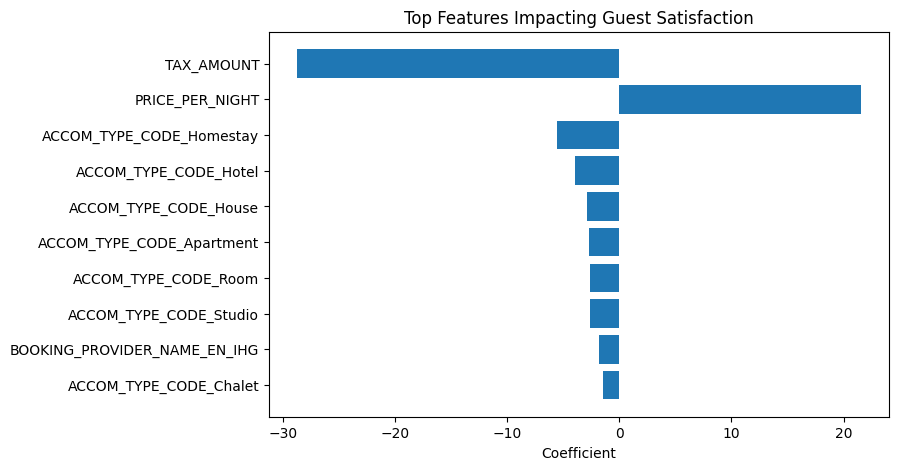

In [164]:
import matplotlib.pyplot as plt

top_coef = coef_df.head(10)
plt.figure(figsize=(8,5))
plt.barh(top_coef['Feature'], top_coef['Coefficient'])
plt.xlabel('Coefficient')
plt.title('Top Features Impacting Guest Satisfaction')
plt.gca().invert_yaxis()
plt.show()


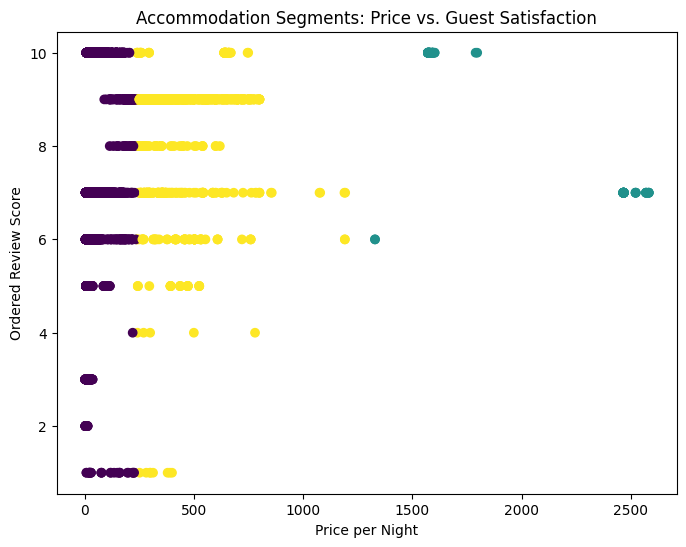

In [165]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

cluster_data = df_clean[['PRICE_PER_NIGHT', 'REVIEW_SCORE_ORDERED']].dropna()
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(cluster_data)

plt.figure(figsize=(8,6))
plt.scatter(cluster_data['PRICE_PER_NIGHT'], cluster_data['REVIEW_SCORE_ORDERED'], c=clusters, cmap='viridis')
plt.xlabel('Price per Night')
plt.ylabel('Ordered Review Score')
plt.title('Accommodation Segments: Price vs. Guest Satisfaction')
plt.show()


In [166]:
# Only drop rows missing key values needed for analysis
df_city = df_clean.dropna(subset=['CITY_NAME_EN', 'PRICE_PER_NIGHT', 'REVIEW_SCORE_ORDERED'])

# Group by city and calculate average price, score, and count
city_summary = df_city.groupby('CITY_NAME_EN').agg(
    avg_price=('PRICE_PER_NIGHT', 'mean'),
    avg_score=('REVIEW_SCORE_ORDERED', 'mean'),
    count=('PRICE_PER_NIGHT', 'count')
).sort_values('avg_score', ascending=False)

# If some cities are still missing, increase the rows displayed
import pandas as pd
pd.set_option('display.max_rows', None)

print(city_summary)


                           avg_price  avg_score  count
CITY_NAME_EN                                          
Riyadh                    427.045639   8.858333    360
Al Madinah Al Munawwarah  343.172208   8.524237    557
Mecca                      60.712252   6.979836  15969
Al Maqrah                  19.668571   6.585714     70


In [167]:
import pandas as pd

# Example: Simulate effect of a 10% price increase for a given property
test_sample = X_test.iloc[0].copy()
for delta in [0, 0.1, 0.2, -0.1]:  # No change, +10%, +20%, -10%
    test_sample_adj = test_sample.copy()
    test_sample_adj['PRICE_PER_NIGHT'] *= (1 + delta)
    # Wrap as DataFrame with correct columns
    pred_score = model.predict(pd.DataFrame([test_sample_adj], columns=X.columns))
    print(f"Price change {delta*100:+.0f}%, predicted satisfaction: {pred_score[0]:.2f}")


Price change +0%, predicted satisfaction: 7.00
Price change +10%, predicted satisfaction: 58.28
Price change +20%, predicted satisfaction: 109.56
Price change -10%, predicted satisfaction: -44.29


In [168]:
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_
}).sort_values('Coefficient', key=abs, ascending=False)
print(coef_df)


                                              Feature  Coefficient
1                                          TAX_AMOUNT   -28.728753
0                                     PRICE_PER_NIGHT    21.547163
5                            ACCOM_TYPE_CODE_Homestay    -5.586529
6                               ACCOM_TYPE_CODE_Hotel    -3.947238
7                               ACCOM_TYPE_CODE_House    -2.841399
3                           ACCOM_TYPE_CODE_Apartment    -2.677183
8                                ACCOM_TYPE_CODE_Room    -2.656105
9                              ACCOM_TYPE_CODE_Studio    -2.628237
18                       BOOKING_PROVIDER_NAME_EN_IHG    -1.779237
4                              ACCOM_TYPE_CODE_Chalet    -1.463671
31                        ROOM_TYPE_CODE_Chalet Rooms    -1.463671
35                        ROOM_TYPE_CODE_Economy Room    -0.944464
21                 BOOKING_PROVIDER_NAME_EN_PRESTIGIA    -0.849313
13          BOOKING_PROVIDER_NAME_EN_ELAF KINDA HOTEL    -0.78

/var/folders/p7/jsggmqd93k98_sqfgnl21f9m0000gp/T/ipykernel_43343/3565251303.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=type_avg.index, y=type_avg.values, palette='Blues_r')


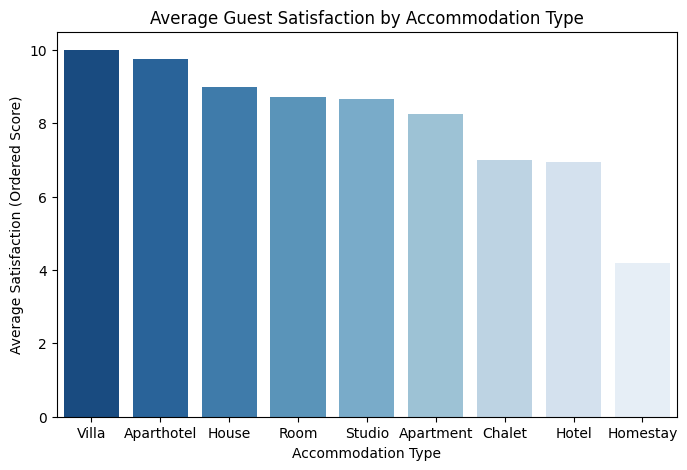

ACCOM_TYPE_CODE
Villa         10.000000
Aparthotel     9.769231
House          9.000000
Room           8.722222
Studio         8.651757
Apartment      8.258126
Chalet         7.000000
Hotel          6.941740
Homestay       4.181818
Name: REVIEW_SCORE_ORDERED, dtype: float64


In [169]:
import matplotlib.pyplot as plt
import seaborn as sns

# Average review score by accommodation type
type_avg = df.groupby('ACCOM_TYPE_CODE')['REVIEW_SCORE_ORDERED'].mean().sort_values(ascending=False)
plt.figure(figsize=(8,5))
sns.barplot(x=type_avg.index, y=type_avg.values, palette='Blues_r')
plt.title('Average Guest Satisfaction by Accommodation Type')
plt.ylabel('Average Satisfaction (Ordered Score)')
plt.xlabel('Accommodation Type')
plt.show()
print(type_avg)


In [170]:
# Simulate predicted satisfaction for different room types at a constant price
base_sample = X_test.iloc[0].copy()

room_types = [col for col in X.columns if col.startswith('ROOM_TYPE_CODE_')]
pred_scores = []

for room in room_types:
    sample = base_sample.copy()
    # Reset all room type columns to 0, set only current room to 1
    for r in room_types:
        sample[r] = 0
    sample[room] = 1
    pred = model.predict(pd.DataFrame([sample], columns=X.columns))[0]
    pred_scores.append((room.replace('ROOM_TYPE_CODE_', ''), pred))

pred_scores = sorted(pred_scores, key=lambda x: x[1], reverse=True)
for name, score in pred_scores:
    print(f"{name}: {score:.2f}")


Suite: 7.86
Villa Rooms: 7.52
Specialty Rooms: 7.19
Deluxe Room: 7.14
Quadruple Room: 7.03
Superior Room: 7.02
Studio: 7.00
Standard Room: 7.00
Triple Room: 6.99
Twin Room: 6.95
King Bed Room: 6.95
Other: 6.90
Classic Room: 6.84
Double Room: 6.74
Family Room: 6.71
Economy Room: 6.18
Chalet Rooms: 5.66


/var/folders/p7/jsggmqd93k98_sqfgnl21f9m0000gp/T/ipykernel_43343/3807802771.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=provider_avg.index, y=provider_avg.values, palette='mako')


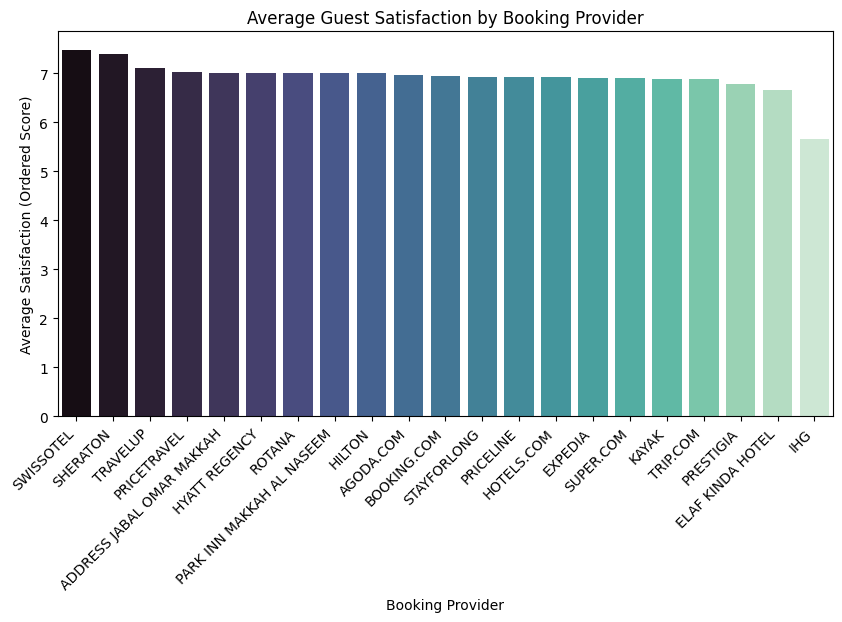

BOOKING_PROVIDER_NAME_EN
SWISSOTEL                    7.485166
SHERATON                     7.407767
TRAVELUP                     7.116071
PRICETRAVEL                  7.021038
ADDRESS JABAL OMAR MAKKAH    7.000000
HYATT REGENCY                7.000000
ROTANA                       7.000000
PARK INN MAKKAH AL NASEEM    7.000000
HILTON                       7.000000
AGODA.COM                    6.963308
BOOKING.COM                  6.953675
STAYFORLONG                  6.937732
PRICELINE                    6.934592
HOTELS.COM                   6.919305
EXPEDIA                      6.917335
SUPER.COM                    6.906667
KAYAK                        6.882302
TRIP.COM                     6.878788
PRESTIGIA                    6.781893
ELAF KINDA HOTEL             6.656000
IHG                          5.666667
Name: REVIEW_SCORE_ORDERED, dtype: float64


In [171]:
# Which booking platforms are associated with the highest satisfaction?
provider_avg = df.groupby('BOOKING_PROVIDER_NAME_EN')['REVIEW_SCORE_ORDERED'].mean().sort_values(ascending=False)
plt.figure(figsize=(10,5))
sns.barplot(x=provider_avg.index, y=provider_avg.values, palette='mako')
plt.xticks(rotation=45, ha='right')
plt.title('Average Guest Satisfaction by Booking Provider')
plt.ylabel('Average Satisfaction (Ordered Score)')
plt.xlabel('Booking Provider')
plt.show()
print(provider_avg)


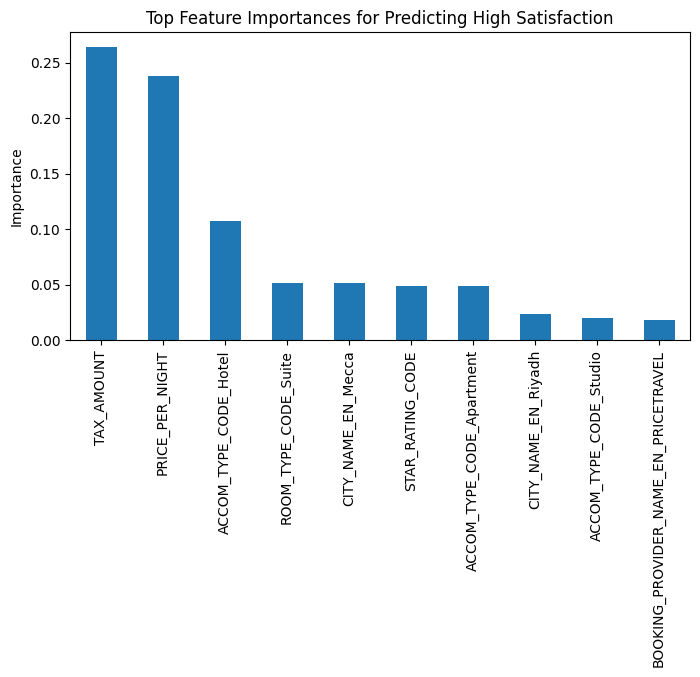

TAX_AMOUNT                              0.264323
PRICE_PER_NIGHT                         0.237810
ACCOM_TYPE_CODE_Hotel                   0.107397
ROOM_TYPE_CODE_Suite                    0.051638
CITY_NAME_EN_Mecca                      0.051213
STAR_RATING_CODE                        0.048908
ACCOM_TYPE_CODE_Apartment               0.048720
CITY_NAME_EN_Riyadh                     0.023779
ACCOM_TYPE_CODE_Studio                  0.019962
BOOKING_PROVIDER_NAME_EN_PRICETRAVEL    0.017941
dtype: float64


In [172]:
from sklearn.ensemble import RandomForestClassifier

# Define "high satisfaction" as 8 or above
df['HIGH_SAT'] = (df['REVIEW_SCORE_ORDERED'] >= 8).astype(int)
X_class = X.copy()
y_class = df.loc[X.index, 'HIGH_SAT']

# Train/test split
from sklearn.model_selection import train_test_split
Xc_train, Xc_test, yc_train, yc_test = train_test_split(X_class, y_class, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(Xc_train, yc_train)

# Feature importances
importances = pd.Series(rf.feature_importances_, index=X_class.columns)
top_importances = importances.sort_values(ascending=False).head(10)
plt.figure(figsize=(8,4))
top_importances.plot(kind='bar')
plt.title('Top Feature Importances for Predicting High Satisfaction')
plt.ylabel('Importance')
plt.show()
print(top_importances)


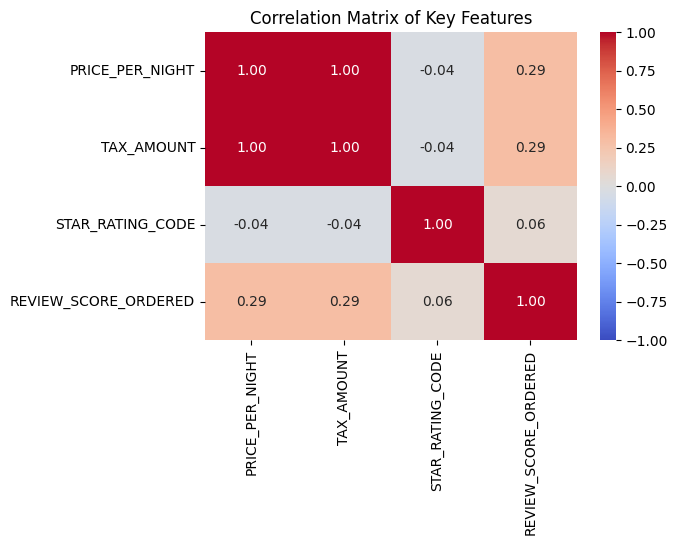

                      PRICE_PER_NIGHT  TAX_AMOUNT  STAR_RATING_CODE  \
PRICE_PER_NIGHT              1.000000    1.000000         -0.038742   
TAX_AMOUNT                   1.000000    1.000000         -0.038742   
STAR_RATING_CODE            -0.038742   -0.038742          1.000000   
REVIEW_SCORE_ORDERED         0.290418    0.290418          0.055816   

                      REVIEW_SCORE_ORDERED  
PRICE_PER_NIGHT                   0.290418  
TAX_AMOUNT                        0.290418  
STAR_RATING_CODE                  0.055816  
REVIEW_SCORE_ORDERED              1.000000  


In [178]:
import matplotlib.pyplot as plt
import seaborn as sns

# Choose only numeric features for correlation
num_cols = [
    'PRICE_PER_NIGHT', 'TAX_AMOUNT', 'STAR_RATING_CODE', 'REVIEW_SCORE_ORDERED'
]
corr = df[num_cols].corr()

plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation Matrix of Key Features')
plt.show()
print(corr)


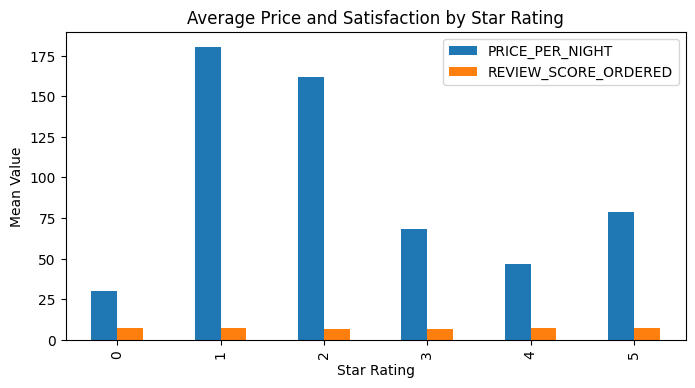

                  PRICE_PER_NIGHT  REVIEW_SCORE_ORDERED
STAR_RATING_CODE                                       
0                       29.919672              7.054098
1                      180.620358              7.327684
2                      162.100330              6.571610
3                       68.480640              6.803106
4                       46.989089              7.222222
5                       78.617133              7.111374


In [174]:
avg_by_star = df.groupby('STAR_RATING_CODE').agg({'PRICE_PER_NIGHT': 'mean', 'REVIEW_SCORE_ORDERED': 'mean'})
avg_by_star.plot(kind='bar', figsize=(8,4))
plt.title('Average Price and Satisfaction by Star Rating')
plt.ylabel('Mean Value')
plt.xlabel('Star Rating')
plt.show()
print(avg_by_star)


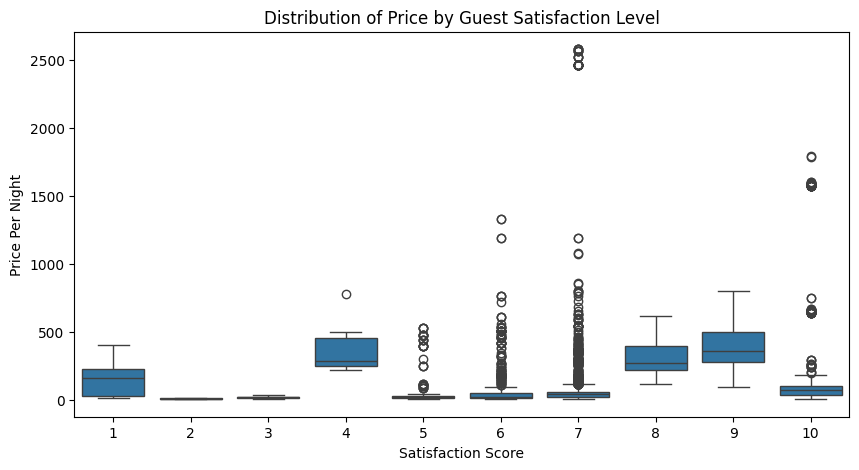

In [175]:
plt.figure(figsize=(10,5))
sns.boxplot(x='REVIEW_SCORE_ORDERED', y='PRICE_PER_NIGHT', data=df)
plt.title('Distribution of Price by Guest Satisfaction Level')
plt.xlabel('Satisfaction Score')
plt.ylabel('Price Per Night')
plt.show()


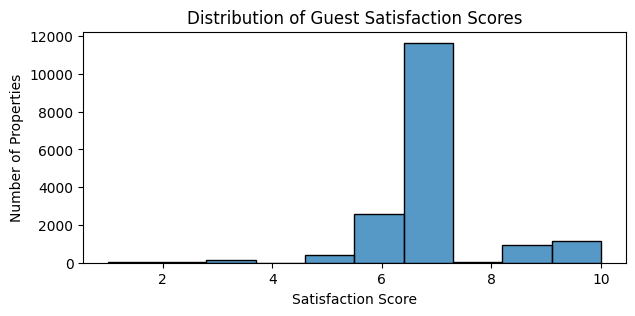

In [176]:
plt.figure(figsize=(7,3))
sns.histplot(df['REVIEW_SCORE_ORDERED'], bins=10, kde=False)
plt.title('Distribution of Guest Satisfaction Scores')
plt.xlabel('Satisfaction Score')
plt.ylabel('Number of Properties')
plt.show()


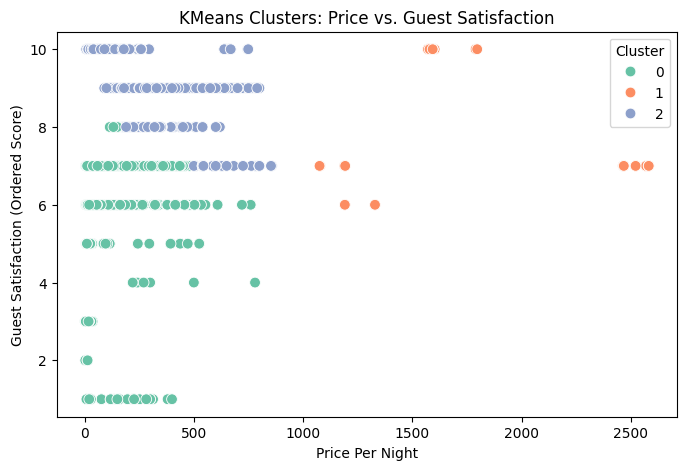

         PRICE_PER_NIGHT  REVIEW_SCORE_ORDERED  Num_Properties
CLUSTER                                                       
0              43.716056              6.716872           14746
1            1935.542169              8.397590              83
2             240.003362              9.456982            2127


In [177]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Use only properties with non-missing values
clust_data = df[['PRICE_PER_NIGHT', 'REVIEW_SCORE_ORDERED']].dropna()

# Standardize features for better clustering (optional but recommended)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
clust_scaled = scaler.fit_transform(clust_data)

# Run KMeans
n_clusters = 3  # Or 4, depending on your data; adjust as you see fit
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(clust_scaled)

# Attach cluster labels to dataframe
clust_data = clust_data.copy()
clust_data['CLUSTER'] = labels

# Plot clusters
plt.figure(figsize=(8,5))
sns.scatterplot(
    x='PRICE_PER_NIGHT', y='REVIEW_SCORE_ORDERED', 
    hue='CLUSTER', palette='Set2', data=clust_data, s=60
)
plt.title('KMeans Clusters: Price vs. Guest Satisfaction')
plt.xlabel('Price Per Night')
plt.ylabel('Guest Satisfaction (Ordered Score)')
plt.legend(title='Cluster')
plt.show()

# Get average profile for each cluster
cluster_profiles = clust_data.groupby('CLUSTER').agg({
    'PRICE_PER_NIGHT': 'mean',
    'REVIEW_SCORE_ORDERED': 'mean',
    'CLUSTER': 'count'
}).rename(columns={'CLUSTER': 'Num_Properties'})
print(cluster_profiles)
